<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1aS4vX-ucDKBmZmZMrBwgjl_DvLAadX2C" width=900/></p>


<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. RAG.

В этом домашнем задании вам предстоит создать туристический RAG, провести EDA и проявить креатив! :)

Вам дан набор данных, содержащий информацию о памятниках, архитектуре и других значимых местах. В данных есть:
* название достопримечательности;
* идентификатор на WikiData;
* город расположения;
* координаты долготы и широты;
* описание (извлеченное из WikiData);
* изображение в формате base64;
* сгенерированное описание изображения (генерация с помощью модели BLIP).

Некоторые из памятников могут встречаться несколько раз, но с различными изображениями, из которых не все могут быть качественными. Для компенсации этого даны текстовые описания.

Часть данных взята с Национальной технологической олимпиады студентов по CV. Базовое решение предполагает использование мультимодального ru-CLIP. Но в данном домашнем задании предлагается решить эту задачу творчески, используя NLP подход.

## Установка и импорт библиотек

In [2]:
!pip install -q gdown torch gcsfs jedi fsspec transformers==4.49 pandas numpy accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl datasets langchain-community ragatouille umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from typing import Optional, List, Tuple

import gdown
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import plotly.express as px
import matplotlib.pyplot as plt

import torch

from sklearn.feature_extraction.text import TfidfVectorizer
from langchain.docstore.document import Document as LangchainDocument
from langchain.vectorstores import FAISS
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.retrievers import TFIDFRetriever

from sentence_transformers import SentenceTransformer

from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

from ragatouille import RAGPretrainedModel

#------------------------------------------------------------------------------------

# pd.set_option("display.max_colwidth", None)

## Загрузка данных (4 балла)

In [4]:
url = 'https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk'
output = 'file.csv'

gdown.download(url, output, quiet=False)

data = pd.read_csv('file.csv')

Downloading...
From (original): https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk
From (redirected): https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk&confirm=t&uuid=b7573d79-06fd-42c6-84a0-b76fcb21a501
To: /content/file.csv
100%|██████████| 672M/672M [00:07<00:00, 95.4MB/s]


In [5]:
data.head(10)

Unnamed: 0    Name   WikiData          City        Lon        Lat  \
0           0  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   
1           1  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   
2           2  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   
3           3  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   
4           4  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   
5           5  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   
6           6  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   
7           7  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   
8           8  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   
9           9  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   

                     description  \
0  спорткомплекс в Екатеринбурге   
1  спорткомплекс в Екатеринбурге   
2  спорткомплекс в Екатеринбурге   
3  спорткомплекс в Екатеринбурге   
4  спорткомплекс в Екатеринбурге   
5  спорткомплекс в Екатеринбурге   
6  спорткомплекс в Екатеринбурге   
7  спорткомплекс в Екатеринбурге   
8  спорткомплекс в Екатеринбурге   
9  спорткомплекс в Екатеринбурге   

                                               image  \
0  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
1  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
2  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
3  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
4  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
5  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
6  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
7  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
8  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
9  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   

                                              en_txt  
0  there are two people that are standing on a tr...  
1  arafed building with a blue and white exterior...  
2  there is a blue and white building with a cloc...  
3  there is a blue and white building with a cloc...  
4  there is a boat that is in the water near a bu...  
5  there is a building with a clock tower in the ...  
6  aerial view of a city with a soccer field and ...  
7  a view of a building with a clock tower on top...  
8   arafed building with a blue and white sign on it  
9  arafed building with a blue and white sign on ...

Для декодирования изображений, закодированных в формате base64, можно использовать следующий код:

In [6]:
import base64
import requests
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from io import BytesIO

In [7]:
def get_image(data):
  image = Image.open(BytesIO(base64.b64decode(data))).convert('RGB')
  return image

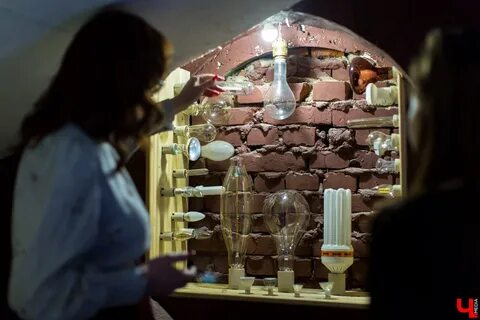

In [8]:
get_image(data.sample(1)['image'].tolist()[0])

В данных есть выбросы — записи, не относящихся к туристическим или историческим объектам. Для очистки данных можно, например, использовать алгоритм TF-IDF: создаем корпус текстов из описаний, применяем TF-IDF, извлекаем наиболее редко или часто встречающиеся слова. Они могут указывать на мусорные данные, такие как мемы, баннеры или личные фото людей. После выделения подозрительных паттернов, можно провести ручную проверку и фильтрацию данных.

Для дальнейшего тестирования и получения чистых сэмплов, рекомендуется взять не менее 100 чистых образцов со стратификацией по городу и названию места. Это можно сделать, выбрав случайным образом несколько образцов из каждой категории (город + название места), чтобы обеспечить равномерное представительство и разнообразие данных.

**!! Важно:** Помните, что чистые сэмплы одного и того же места выдадут примерно одинаковое описание. Есть несколько стратегий, как повысить разнообразие ответов:

- выбор одного самого лучшего:
  - самое длинное описание
  - смое подходящие по мнению LLM
- конкатенация описаний (но важно не сконкатенировать слишком много)

Изображения можно отдать в мета-данные.

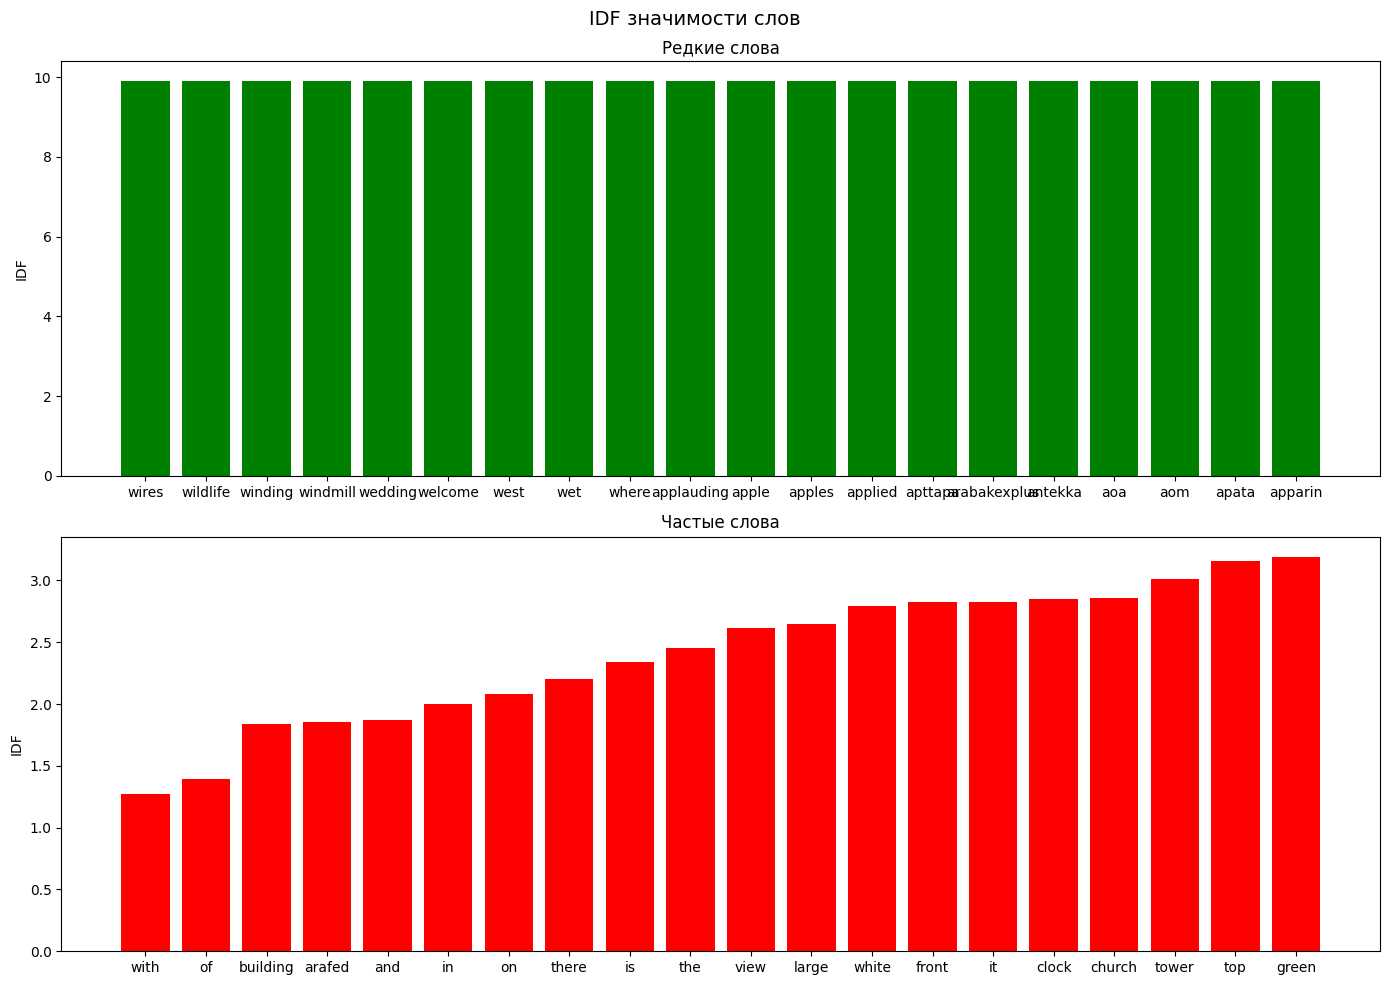

In [9]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(data.en_txt)
words = vectorizer.get_feature_names_out()

N = 20 # Кол-во слов для отображения
def most_idf_words(words, idf, count=N):
  idf_df = pd.DataFrame({
      'word': words,
      'idf': idf
  }).sort_values(by='idf', ascending=False)
  top_idf = idf_df.head(count)
  bottom_idf = idf_df.tail(count).sort_values(by='idf')

  fig, axes = plt.subplots(2, 1, figsize=(14, 10))
  fig.suptitle(f"IDF значимости слов", fontsize=14)

  axes[0].bar(top_idf['word'], top_idf['idf'], color='green')
  axes[0].set_title("Редкие слова")
  axes[0].set_ylabel("IDF")

  axes[1].bar(bottom_idf['word'], bottom_idf['idf'], color='red')
  axes[1].set_title("Частые слова")
  axes[1].set_ylabel("IDF")

  plt.tight_layout()
  plt.show()


most_idf_words(words, vectorizer.idf_)

In [10]:
tfidf_sums = tfidf_matrix.sum(axis=1).A1

df = pd.DataFrame({
    'text': data.en_txt,
    'tfidf_sum': tfidf_sums
})

top_docs = df.sort_values(by='tfidf_sum', ascending=False).head(N)
bottom_docs = df.sort_values(by='tfidf_sum', ascending=True).head(N)

print(f"\nTop {N} текстов по сумме TF-IDF:\n{'='*40}")
for i, row in top_docs.iterrows():
    print(f"\nTF-IDF Score: {row['tfidf_sum']:.4f}")
    print(f"Текст: {row['text']}")

print(f"\nBottom {N} текстов по сумме TF-IDF:\n{'='*40}")
for i, row in bottom_docs.iterrows():
    print(f"\nTF-IDF Score: {row['tfidf_sum']:.4f}")
    print(f"Текст: {row['text']}")


Top 20 текстов по сумме TF-IDF:

TF-IDF Score: 3.6962
Текст: there is a large building with a green roof and a lot of cars parked in front of it

TF-IDF Score: 3.6739
Текст: there is a large yellow building with a green roof and a lot of cars parked in front of

TF-IDF Score: 3.6351
Текст: there is a large building with a green roof and a white car parked in front of it

TF-IDF Score: 3.6351
Текст: there is a large building with a green roof and a white car parked in front of it

TF-IDF Score: 3.6212
Текст: there is a building with a clock on the roof and a car parked in front of it

TF-IDF Score: 3.5819
Текст: there is a building that has snow on the ground and a car parked in front of it

TF-IDF Score: 3.5292
Текст: painting of a white house with a green roof and a car parked on the side of the road

TF-IDF Score: 3.5183
Текст: there are many people sitting in a classroom with desks and a man standing at the front of

TF-IDF Score: 3.5127
Текст: there are many cars and people walkin

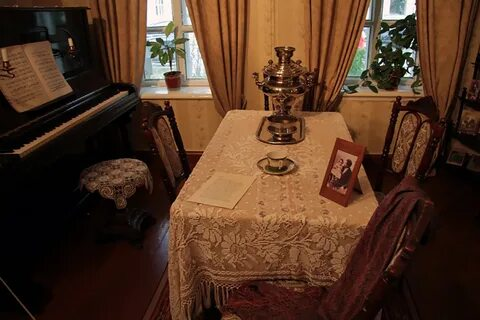

In [11]:
low_threshold = 2.2
high_threshold = 2.8

low_tfidf = data[df['tfidf_sum'] < low_threshold]
high_tfidf = data[df['tfidf_sum'] > high_threshold]

get_image(low_tfidf.sample(1)['image'].tolist()[0])

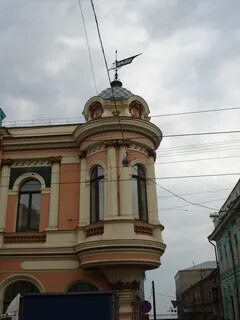

In [12]:
get_image(high_tfidf.sample(1)['image'].tolist()[0])

---

Как видно, что данные засорены. Удалим их из обучающего датасета

---

In [13]:
stop_words = ['школа', 'предприятие', 'специалистов', 'училище', 'учреждение']
trash_words = ['planet', 'star', 'soldier', 'people', 'man', 'young', 'zazne', 'aoa', '1930s']
stop_pattern = '|'.join(stop_words)
trash_pattern = '|'.join(trash_words)
filtered_data = data[
    (df['tfidf_sum'] > low_threshold)\
    & (df['tfidf_sum'] < high_threshold)\
    & (~data['description'].str.contains(stop_pattern, case=False, regex=True, na=False))\
    & (~data['en_txt'].str.contains(trash_pattern, case=False, regex=True, na=False))
].dropna()
len(filtered_data)

5011

0 there is a room with a chandelier and a lot of glass
1 arafed brick building with a steeple and a steeple on the side
2 arafed view of a city with a church and a church steeple
3 arafed church with a steeple and a dome on top
4 arafed building with a green dome and a white fence
5 there is a small plane on top of a building in a city
6 arafed wall of paintings with paintings of men and women
7 an old photo of a church with a steeple and a steeple
8 arafed building with a golden spire and a steeple on top
9 map of a city with a blue marker on it
10 arafed apartment building with a car parked in front of it
11 arafed wooden church in a field with a sky background
12 statue of a bear and a cat in a park
13 there is a small church with a steeple and a steeple on the side
14 arafed view of a castle with a tower and a walkway
15 arafed view of a park with a fountain and a lake
16 a close up of a very ornately decorated church with a chandelier
17 map of a street with a red line and a red l

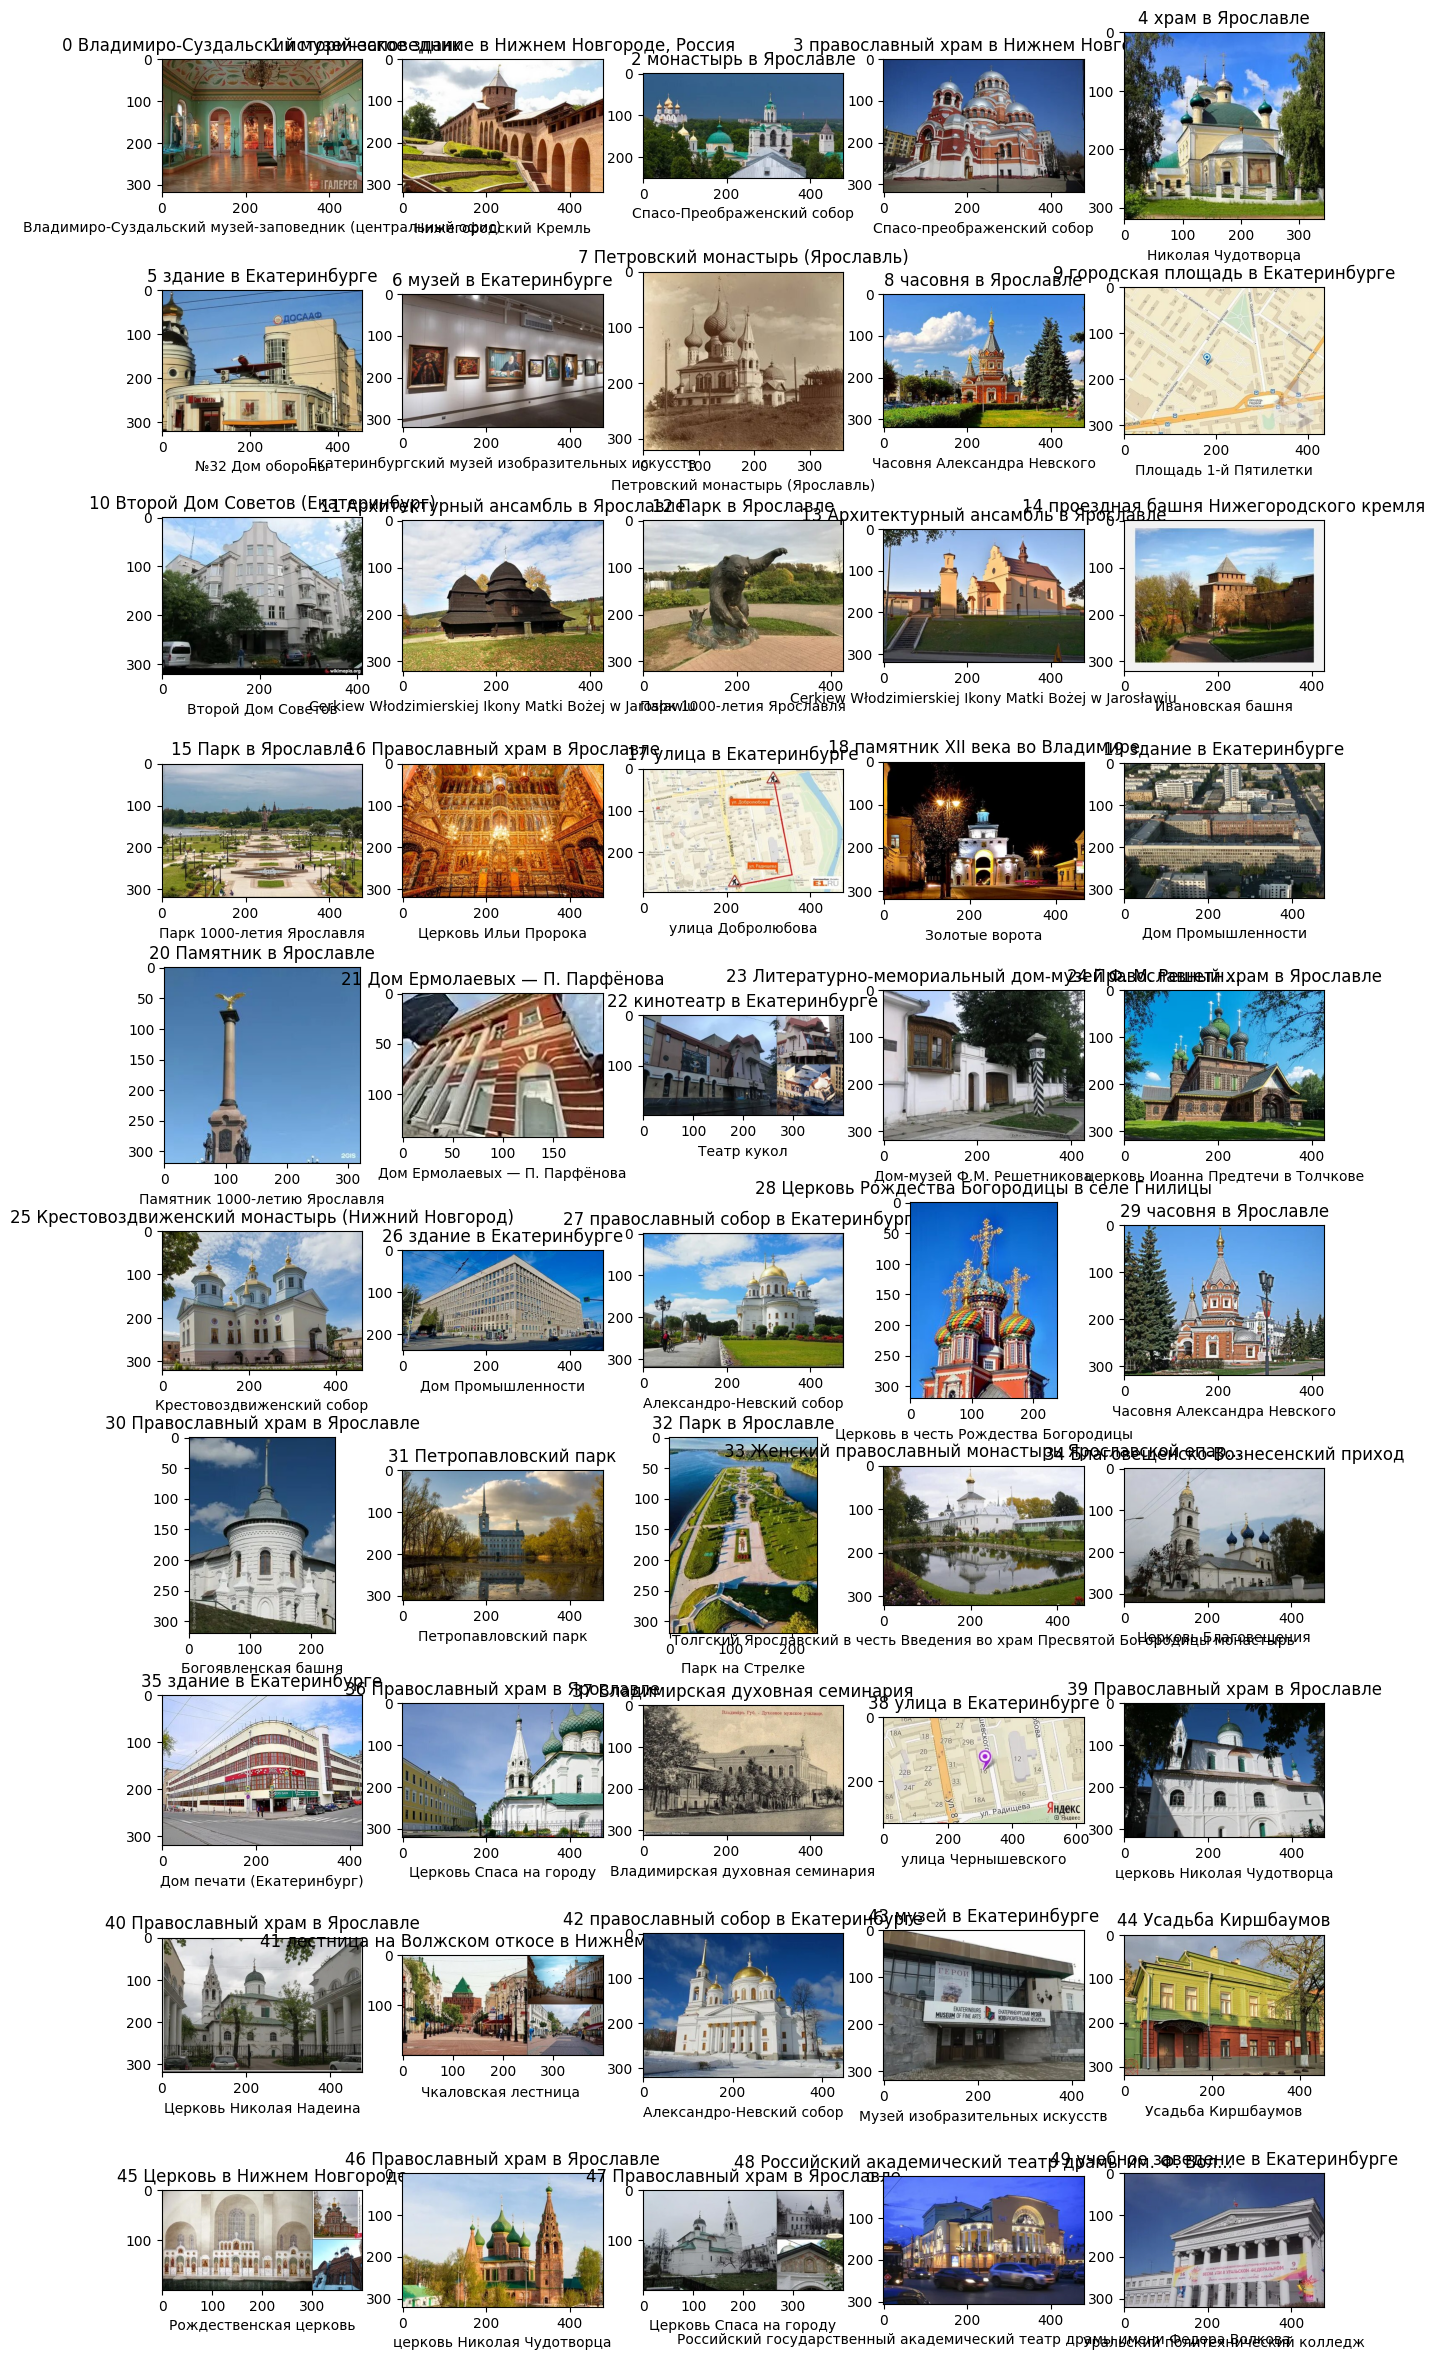

In [14]:
i = int(25 ** 0.5)
fig, axs = plt.subplots(i*2, i, figsize=(15, 30))
fig
for j in range(i*2):
  for k in range(i):
    index = j*i+k
    sample = filtered_data.sample(1)
    img = get_image(sample['image'].tolist()[0])
    axs[j, k].imshow(img)
    desc = str(index)+ ' ' + sample['description'].tolist()[0]
    if len(desc) > 50:
      desc = desc[:50] + '...'
    axs[j, k].set_title(desc)
    axs[j, k].set_xlabel(sample['Name'].tolist()[0])
    print(index, sample['en_txt'].tolist()[0])
plt.show()

---

Таким методом производится анализ и ручная обработка датасета.

---

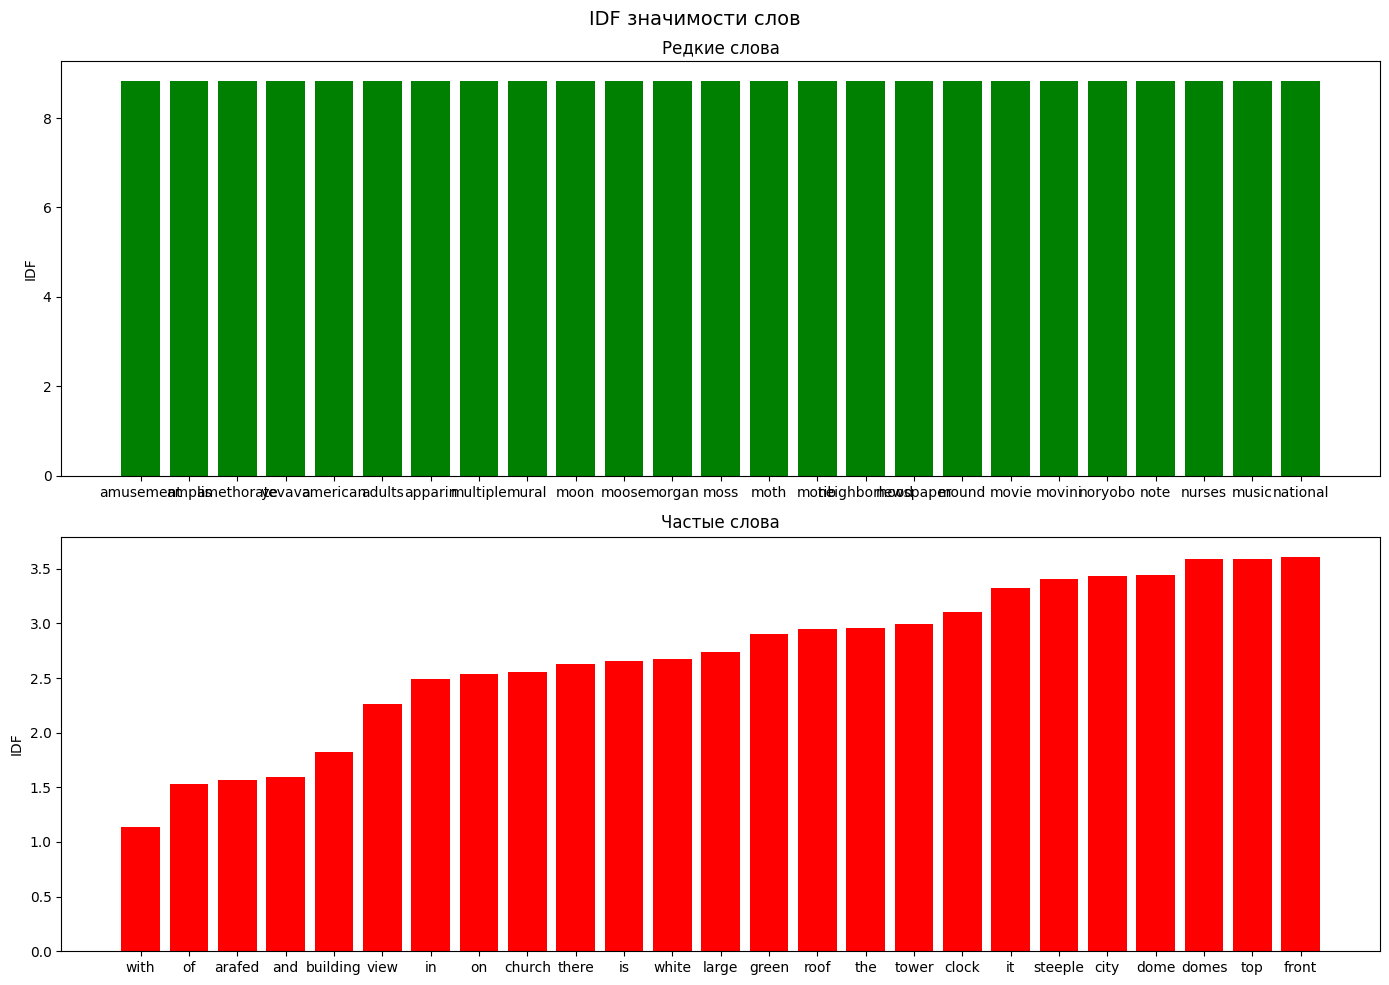

In [15]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(filtered_data.en_txt)
words = vectorizer.get_feature_names_out()

most_idf_words(words, vectorizer.idf_, 25)

In [16]:
from typing import Literal

def get_clean_samples(df: pd.DataFrame, strategy: Literal['concat', 'longest']) -> LangchainDocument:
    """
    Возвращает датафрейм чистых, стратифицированных сэмплов
    по уникальным парам (City, Name). Выбирает лучшие описания по стратегии.
    strategy: 'longest' или 'concat'
    """

    groups = df.groupby(['City', 'Name'])
    selected_rows = []

    for (city, name), group in groups:
        if strategy == "longest":
            # Выбираем самое длинное описание
            best_row = group.loc[group['description'].str.len().idxmax()]
            selected_rows.append(best_row)

        elif strategy == "concat":
            # Конкатенируем первые 2–3 описания (но не длиннее 500 символов)
            descriptions = group['description'].dropna().tolist()
            concat_desc = ' '.join(descriptions[:3])
            concat_desc = concat_desc[:1000]

            # Используем первую строку как основу
            base_row = group.iloc[0].copy()
            base_row['description'] = concat_desc
            selected_rows.append(base_row)

    data = pd.DataFrame(selected_rows).reset_index(drop=True)
    result = [
        LangchainDocument(page_content=doc["en_txt"], metadata={"image": doc["image"], 'name': doc['Name'], 'desc': doc['description']}) for _, doc in data.iterrows()
    ]
    return result

longest_docs = get_clean_samples(filtered_data, "longest")
concat_docs = get_clean_samples(filtered_data, "concat")

len(longest_docs), len(concat_docs)

(308, 308)

Здесь предлагаем вам построить RAG с использованием моделей, которые не были представлены на семинаре (включая другие векторные базы данных). Можно воспользоваться материалами по этой ссылке: [data_connection/vectorstores](https://python.langchain.com/v0.1/docs/modules/data_connection/vectorstores/).

!Важно, не забудьте отранжировать чанки текстов с помощью `ragatouille`. На практике порядок текстов в промпте влияет на точность ответа.

In [17]:
def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str],
) -> List[LangchainDocument]:
    """
    Разобъём документы на блоки максимального размера `chunk_size` и вернём список документов.
    """
    text_splitter = CharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    return docs_processed

In [18]:
name_models = ["cointegrated/LaBSE-en-ru", "cointegrated/rubert-tiny2", "sentence-transformers/all-mpnet-base-v2", "thenlper/gte-small"]
user_query = "Better places for Russia"
rags = {}

for model_name in name_models:
  embedding_model = HuggingFaceEmbeddings(
      model_name=model_name,
      multi_process=True,
      model_kwargs={"device": "cuda"},
      encode_kwargs={"normalize_embeddings": True},
  )
  docs_processed = split_documents(512, longest_docs, model_name)
  database = FAISS.from_documents(
      docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
  )
  rags[model_name] = [database, embedding_model, docs_processed]

<ipython-input-18-a29e4df37aa5>:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/516M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/521k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Выполните визуализацию эмбеддингов при помощи метода главных компонент (PCA) и Uniform Manifold Approximation and Projection (UMAP). Пожалуйста, выполните PCA независимо от pacmap.

In [19]:
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


def scale_shape(embeddings: torch.Tensor, n_components=2, mode: Literal['pca', 'umap']='pca'):
  scaled_embeddings = StandardScaler().fit_transform(embeddings)
  result = None
  match mode:
    case 'pca':
      pca = PCA(n_components=n_components)
      result = pca.fit_transform(scaled_embeddings)
    case 'umap':
      umap_model = umap.UMAP(n_components=n_components)
      result = umap_model.fit_transform(scaled_embeddings)
  return result

In [20]:
def plot_embeddings(docs_coord: torch.Tensor, docs_processed: list[LangchainDocument], user_query: str, title:str):
  df = pd.DataFrame.from_dict(
    [
        {
            "x": docs_coord[i, 0],
            "y": docs_coord[i, 1],
            "source": docs_processed[i].metadata["name"],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": docs_coord[-1, 0],
            "y": docs_coord[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
      ]
  )

  fig = px.scatter(
      df,
      x="x",
      y="y",
      color="source",
      hover_data="extract",
      size="size_col",
      symbol="symbol",
      color_discrete_map={"User query": "black"},
      width=1700,
      height=700,
  )
  fig.update_traces(
      marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
      selector=dict(mode="markers"),
  )
  fig.update_layout(title=f"<b>{title}</b>",)
  fig.show()

In [21]:
for model_name, (database, embedding_model, docs) in rags.items():
  query_vector = embedding_model.embed_query(user_query)
  embeddings_2d = [
      list(database.index.reconstruct_n(idx, 1)[0]) for idx in range(len(docs))
  ] + [query_vector]
  coords = scale_shape(embeddings_2d)
  plot_embeddings(coords, docs, user_query, title=model_name)

# RAGAS (3 балла)

RAGAS - это система, созданная для автоматической оценки эффективности модели RAG. Она представляет собой комплексный инструмент, способный оценить как качество извлечения информации, так и качество созданного текста. Это достигается благодаря использованию различных метрик, которые анализируют разные аспекты ответов, сгенерированных языковой моделью.



## Метрики оценки в RAGAS

### Faithfulness
Оценивает, насколько ответы языковой модели верно передают информацию, содержащуюся в источниках данных. Это критически важно, чтобы гарантировать, что модель не искажает или не меняет информацию при её интерпретации.

---

$
Faithfulness = \frac{\text{|Number of claims that can be inferred from given context|}}{\text{|Total number of claims in the generated answer|}}
$

### Answer Relevancy
Демонстрирует, насколько ответы соответствуют заданным вопросам. Это важный аспект, так как даже правильный ответ с технической точки зрения может быть ненужным, если он не отвечает на конкретный вопрос пользователя.

---

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} cos(E_{g_i}, E_o)$

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} \frac{E_{g_i} \cdot E_o}{\|E_{g_i}\|\|E_o\|}$

Где:

* $E_{g_i}$ - это эмбеддинг сгенерированного ответа $i$

* $E_o$ - это эмбеддинг исходного вопроса.

* $N$ - это количество сгенерированных вопросов, которое по умолчанию равно 3.

### Context Recall и Context Precision
Эти метрики измеряют эффективность модели в учете контекста вопроса для формирования ответа. "Context Recall" оценивает количество использованной информации из контекста в ответе, в то время как "Context Precision" оценивает точность и релевантность использования контекстной информации.

---

* $ \text{context recall} = \frac{\text{|GT sentences that can be attributed to context|}}{\text{|Number of sentences in GT|}} $
* $Context Precision@k = \frac{\sum \text{precision@k}}{\text{total number of relevant items in the top K results}}$
  * $Precision@k = \frac{\text {true positives@k}}{\text{(true positives@k + false positives@k)}}$

### Answer Semantic Similarity
Оценивает степень семантической близости между ответом модели и эталонным ответом. Это позволяет определить, насколько естественно и точно модель способна воссоздавать человеческий язык.

### Answer Correctness
Оценка корректности ответа. Это последний шаг в проверке, чтобы убедиться, предоставляет ли модель точную и достоверную информацию в своем ответе.

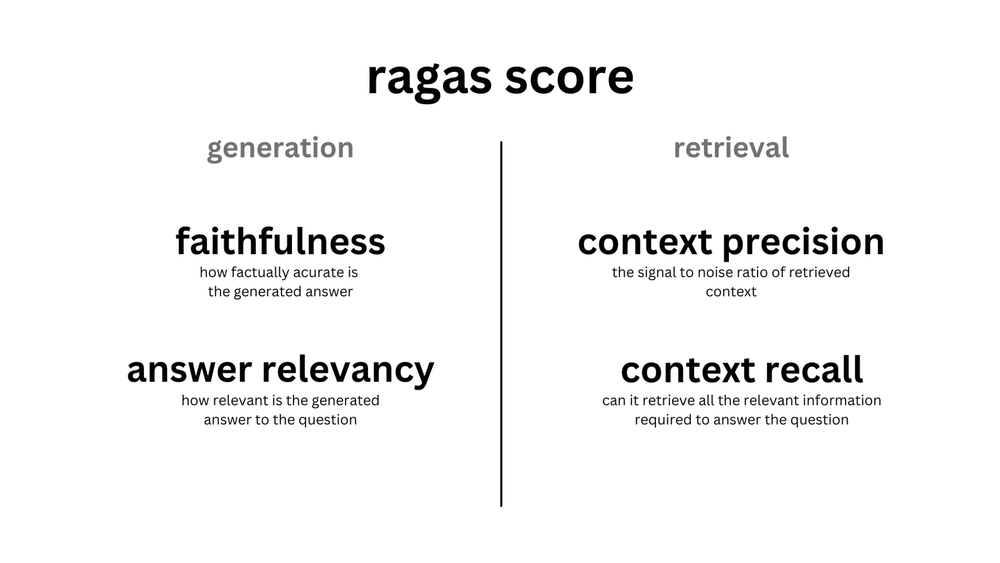

В этом задании вам нужно реализовать метрику answer_relevancy в коде. Опционально за допбаллы можно реализовать другие метрики.

Для этого датасет нужно привести к виду, в котором будут следующие поля:

### 1. question
- Смысл: Эта колонка содержит вопросы, на которые нужно найти ответы. В контексте задач QA, это основная информация, которую модель должна обработать для генерации ответа.
- Пример: "Каковы преимущества RAG?"

### 2. ground_truths
- Смысл: В этой колонке находятся правильные ответы на соответствующие вопросы. Это может использоваться для оценки производительности модели, так как позволяет сравнить сгенерированные ответы с эталонными.
- Пример: "RAG улучшает качество генерации, используя внешние источники информации."

### 3. answer
- Смысл: Эта колонка содержит ответы, которые генерирует модель на основе заданных вопросов. Это может быть результат работы модели, которую вы тестируете или обучаете.
- Пример: "RAG позволяет моделям извлекать информацию из внешних источников, что улучшает их способность отвечать на сложные вопросы."

### 4. contexts
- Смысл: Эта колонка предоставляет контекст или дополнительную информацию, которая может быть полезна для понимания вопроса или для формирования ответа. Это может быть текст, из которого был извлечен ответ, или другие релевантные документы.
- Пример: "RAG (Retrieval-Augmented Generation) — это метод, который использует внешние базы данных для получения информации при генерации текста."

HINT: Поле question можно тоже сгенерировать. Например, можно попросить модель задать вопрос по описанию изображения.

HINT: Для answer_relevancy нужны не все поля

HINT: Инференс такого эксперимента может быть долгим. План минимум: возьмите 100 случайных сэмплов.

In [22]:
QUESTIONS = {
  "Architectural Descriptions": [
    "Find a building with colorful onion domes",
    "What is the cathedral with blue domes and golden stars?",
    "Which church has a wooden roof on an island?",
    "A Stalinist-style skyscraper with a spire and clock — where is it?",
    "Which Kremlin tower has a red star on top?",
    "What is the white cathedral with five domes in Yaroslavl?",
    "Where is the red-brick building with battlements and towers?",
    "Find a university with a skyscraper-like tower",
    "Are there any Art Nouveau buildings with mosaics in Russia?",
    "What's the rotunda with columns by the embankment?"
  ],
  "Cities and Regions": [
    "List of architectural landmarks in Kazan",
    "Show photos of churches in Karelia",
    "Where can I see wooden churches built without nails?",
    "Which cathedral in Vologda has golden domes and white walls?",
    "Show historical buildings in Tomsk",
    "Which city has a white Kremlin and monastery ensemble?",
    "Where can I find Ural Constructivist architecture?",
    "German-style architecture in Kaliningrad — show me",
    "Find a city with a brick water tower and a small chapel",
    "In which city is St. Basil's Cathedral located?"
  ],
  "Churches and Cathedrals": [
    "Where is the tallest Orthodox cathedral located?",
    "A white-stone monastery on an island — what is it?",
    "Find a church with a tented dome and narrow windows",
    "What's the cathedral in St. Petersburg with a colonnade?",
    "Show photos of the Assumption Cathedral in Vladimir",
    "Which church holds the relics of St. Nicholas?",
    "A wooden church with many domes by the water — what is it?",
    "Red-brick church with two towers — where is it?",
    "Monastery surrounded by fortified walls — identify it",
    "Cathedral with green domes — where is it?"
  ],
  "Monuments and Sculptures": [
    "Where is the huge statue of a woman with a sword?",
    "Show the monument of Peter the Great on horseback",
    "Find the bronze elephant sculpture — where is it?",
    "Who is depicted on the monument at Kazan University?",
    "Where is the statue of Lenin with an outstretched hand?",
    "Where is the Mayakovsky monument in Moscow?",
    "Find a monument shaped like an arch with horses",
    "Who is depicted in the giant granite head monument?",
    "Where is the monument with stars and ribbons?",
    "Where is the 'Worker and Kolkhoz Woman' sculpture?"
  ],
  "Architectural Styles": [
    "Examples of Russian Baroque architecture",
    "Show Constructivist buildings in Yekaterinburg",
    "Where can I see Classical architecture in Russia?",
    "Gothic-style buildings in Russia — list some",
    "Examples of wooden Art Nouveau",
    "Churches in tent-roof style — show me",
    "What does Pskov-style architecture look like?",
    "Buildings with stucco and sculpted facades",
    "Half-timbered houses in Kaliningrad",
    "Where to see buildings with turrets and stained glass?"
  ],
  "Detail-Oriented Descriptions": [
    "Building with columns and lion statues at the entrance",
    "Cathedral with a helmet-shaped dome",
    "Church with blue domes and golden crosses",
    "Monument of a woman holding a torch — where is it?",
    "Kremlin with red walls and towers — identify it",
    "Tower with bells and a clock — where is it?",
    "Cathedral with round windows and a white facade",
    "Brick building with carved window frames",
    "Church with frescoes on the facade — location?",
    "What is the building with balconies and stucco on the corner?"
  ],
  "Universities and Cultural Buildings": [
    "Where is the Moscow State University building on Sparrow Hills?",
    "Show architecture of St. Petersburg State University",
    "What is the architectural style of Tomsk University?",
    "Find the Kazan University building",
    "Where is the Ural State University of Architecture located?",
    "What is the building with muses and columns?",
    "Photos of the Academy of Arts in St. Petersburg",
    "Where is the Moscow Architecture Institute (MARCHI)?",
    "Architecture of Moscow Conservatory",
    "Where is the oldest university in Siberia?"
  ],
  "Tourist Routes": [
    "What are the architectural landmarks in Nizhny Novgorod?",
    "Walking route for churches in Rostov Veliky",
    "What to see in Pskov's historic center?",
    "Top 5 architectural sites in Samara",
    "Where is the oldest tower in Suzdal?",
    "Find an ensemble with a bell tower and refectory",
    "Churches in Vologda city center — show a map",
    "Monuments and churches on the Astrakhan embankment",
    "Where to see examples of merchant architecture?",
    "Arched bridges and aqueducts in Russia — show me"
  ],
  "General Knowledge": [
    "What architectural styles are found in Russia?",
    "Where is the oldest building in Russia located?",
    "Top 5 most beautiful churches in Russia",
    "Where is the tallest monument in Russia?",
    "Examples of buildings with tented roofs",
    "What are onion domes and where to see them?",
    "Examples of Brick Gothic in Russia",
    "Where to find Italian-style architecture in Russia?",
    "Which buildings were designed by Rastrelli?",
    "Buildings from the era of Nicholas II — show examples"
  ],
  "Rare and Specific Requests": [
    "Where is the windowless chapel located?",
    "Building with triangular facade and angel sculptures",
    "Find a church built inside a cave",
    "Where can I see an Old Believer church?",
    "Church standing directly on the water — where is it?",
    "Architecture on the Solovetsky Islands",
    "Show a building made entirely of white stone",
    "Are there any round churches in Russia?",
    "Church shaped like a cross — location?",
    "Building with frescoes on outer walls — photo and info"
  ]
}

In [23]:
READER_MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Device set to use cuda:0


In [24]:
print(READER_LLM("Что ты расскажешь про RAG модель?"))

[{'generated_text': ' Сколько вvariants есть для RAG? Какие аспекты важны для выбора вvariants?\n</think>\n\nRAG（ Rapidly Appropriate Generalization）模型是一种基于注意力机制的自然语言生成模型，广泛应用于聊天机器人和文本交互中。以下是关于RAG模型的一些关键信息：\n\n### 1. **RAG 模型的基本结构**\n- **注意力机制**：RAG模型利用大语言模型（如 BERT、T5）的注意力分布来捕捉长距离依赖关系。\n- **多变性**：通过调整注意力权重，可以实现不同级别的可解释性和灵活性。\n\n### 2. **RAG 模型的 variants**\nRAG模型根据不同的需求设计了多种变体，主要依据以下因素：\n- **可解释性**：某些变体更注重输出的可解释性，适合需要高可解释性的应用场景。\n- **性能**：某些变体在处理长距离依赖或复杂语义时表现更好。\n- **效率**：某些变体在训练或推理过程中更加高效。\n\n### 3. **RAG 变体的选择因素**\n选择合适的 RAG 变体取决于以下几个方面：\n- **具体应用场景**：如果是用于实时对话，可能需要更高的可解释性和灵活性；如果是用于生成高质量内容，可能需要更强的长距离依赖能力。\n- **用户需求**：是希望模型更加透明、更容易理解还是能够更好地处理复杂的语义问题。\n- **计算资源**：如果计算资源有限，可能需要选择更高效的变体。\n\n### 4. **RAG 模型的关键 aspects for variant selection**\n- **可解释性与透明度**：决定于是否需要明确的输出逻辑或规则。\n- **长距离依赖能力**：决定了模型在处理长距离语义时的表现。\n- **计算复杂度**：影响模型的训练速度和推理效率。\n- **适用场景**：确定模型是否适用于特定类型的任务。\n\n### 总结\nRAG 模型提供了丰富的变体选择，可以根据具体需求进行调整。在实际应用中，应综合考虑模型的可解释性、长距离依赖能力、计算效率以及适用场景，以确保最佳的性能和用户体验。'}]


In [25]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]

RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)

In [26]:
from typing import TypedDict, Optional


class Prediction(TypedDict):
  question: str
  ground_truths: Optional[str]
  answer: str
  contexts: str


class ResultType(Prediction):
  theme: str
  relevancy: float

In [27]:
from sklearn.metrics.pairwise import cosine_similarity


def create_pompt(question: str, model_name="cointegrated/LaBSE-en-ru", k=5)-> tuple[str, str]:
  """Возвращает промпт и контекст."""
  if model_name not in rags:
    return ''
  retrieved_docs = rags[model_name][0].similarity_search(query=question, k=k)
  context = "\nДокументы:\n"
  context += "".join([f"Документ {str(i)}:::\n{doc.page_content}\nДостопримечательность: {doc.metadata['name']} - {doc.metadata['desc']}" for i, doc in enumerate(retrieved_docs)])
  prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)
  return prompt, context


def answer_relevancy(question: str, answer: str, model_name="cointegrated/LaBSE-en-ru") -> float:
  if model_name not in rags:
    return ''
  embedding_model = rags[model_name][1]
  emb_1 = embedding_model.embed_query(user_query)
  emb_2 = embedding_model.embed_query(question)
  return cosine_similarity([emb_1], [emb_2])[0][0]

# Протестируйте ваш RAG (3 балла)

In [28]:
result: list[ResultType] = []

for theme, questions in QUESTIONS.items():
  for question in questions:
    prompt, context = create_pompt(question)
    answer = READER_LLM(prompt)[0]['generated_text']
    relevancy = answer_relevancy(question, answer)
    result.append({
        'question': question,
        'answer': answer,
        'contexts': context,
        'theme': theme,
        'relevancy': relevancy,
    })

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [41]:
result

[{'question': 'Find a building with colorful onion domes',
  'answer': 'Okay, so I\'m trying to figure out how to find a building with colorful onion domes based on the provided documents. Let me go through each document one by one to see if any mention such structures.\n\nFirst, Document 0 talks about bright-colored apartment buildings with a playground. The copyright info mentions Frunze, but nothing about domes or onion shapes. So nope, that\'s not it.\n\nDocument 1 describes a building with many windows and lights, attributed to the Ektzergovoy museum. Again, no mention of domes or onion designs. Moving on.\n\nDocument 2 discusses a brightly colored building with a red door and green roof. This seems like a typical residential or commercial structure, but there\'s no specific reference to onion domes here either.\n\nDocument 3 is about a large yellow building with lots of windows. The copyright is Ushakov, but again, no details on domes or onion structures. \n\nFinally, Document 4 

In [44]:
avg_relevancy = sum([res['relevancy'] for res in result]) / len(result)
avg_relevancy

0.10143413460649424

# Дополнительная часть (+3 балла)

Реализуйте одну из метрик retrieval-части на выбор.

Для того, чтобы понять model as a judge подход из RAGAS, советуем посетить [этот кукбук](https://huggingface.co/learn/cookbook/en/rag_evaluation)

In [53]:
prompt_2 = [
    {
        "role": "system",
        "content": """You are given a question from a user and a document retrieved from a database.
Your task is to determine whether the document contains information that is helpful or relevant for answering the question.
Respond with a single word: "Yes" if the document helps answer the question in any way, or "No" if it does not.""",
    },
    {
        "role": "user",
        "content": """Question:
{question}

Document:
{document}

Answer with only "Yes" or "No".""",
    },
]

RAG_PROMPT_TEMPLATE_2 = tokenizer.apply_chat_template(
    prompt_2, tokenize=False, add_generation_prompt=True
)

In [60]:
def is_document_relevant(question: str, document: str) -> bool:
    prompt = RAG_PROMPT_TEMPLATE_2.format(question=question, document=document)
    answer = READER_LLM(prompt)[0]['generated_text']
    return 'yes' in answer


def answer_precision(question: str, docs: list[str]) -> float:
    if not docs:
        return 0.0

    relevant_count = sum(
        is_document_relevant(question, doc) for doc in docs
    )

    return relevant_count / len(docs)

In [61]:
answer_precision(result[0]['question'], result[0]['contexts'].split(':::')[1:])

0.2

In [63]:
import json

with open('result.txt', '+w') as f:
  json.dumps(result)